### Tutorial 08: Building a Convolutional Neural Network (CNN) from Scratch

In this tutorial, we’ll learn how to build a Convolutional Neural Network (CNN) from scratch using Python and TensorFlow/Keras. CNNs are widely used in image-related tasks like classification, object detection, and segmentation.

We’ll walk through the following steps:

1. **Set Up Environment**
2. **Load and Prepare the Dataset**
3. **Design the CNN Architecture**
4. **Compile and Train the CNN**
5. **Evaluate the Model**
6. **Make Predictions**

---

In [1]:
from torchvision import models, datasets, transforms
import torch.nn as nn
from torch.utils.data import DataLoader
import torch

In [2]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms  = transforms.Compose([transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

                                                            
train_dir = "../data/car_truck/train"  
test_dir = "../data/car_truck/test"  

train_datasets = datasets.ImageFolder(train_dir, transform = train_transforms)
test_datasets  = datasets.ImageFolder(test_dir,  transform = test_transforms)

print(f"Training samples: {len(train_datasets)}, Testing samples: {len(test_datasets)}")

train_loader = DataLoader(train_datasets, batch_size = 64, shuffle = True)
test_loader  = DataLoader(test_datasets,  batch_size = 64)

Training samples: 619, Testing samples: 168


In [3]:
class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 56 * 56, 128),  
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),  
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(num_classes=2)
model.to(device)

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=200704, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [4]:
import time
import torch
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 5
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)   

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

print("Finished fine-tuning")

computation_time = time.time() - start_time
print(f"Computation Time: {computation_time} seconds")

Epoch 1/5, Loss: 0.6979019045829773
Epoch 2/5, Loss: 0.7021398961544036
Epoch 3/5, Loss: 0.6905798017978668
Epoch 4/5, Loss: 0.6784288108348846
Epoch 5/5, Loss: 0.6720305025577545
Finished fine-tuning
Computation Time: 19.63296389579773 seconds


In [5]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

model.eval()

correct = 0
total = 0
y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        prob, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_pred.extend(predicted.cpu())  # Move predicted values back to CPU for further processing
        y_true.extend(labels.cpu())    # Move true labels back to CPU for further processing

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:0.3f}%')

Accuracy: 61.905%


In [6]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np

y_pred_list = [item.item() for item in y_pred]  # Using .item() to get the scalar value from each tensor
y_true_list = [item.item() for item in y_true]

class_labels = pd.DataFrame({'Predicted': y_pred_list, 'Truth_Label': y_true_list})
class_counts = class_labels['Truth_Label'].value_counts().sort_index()
cm = confusion_matrix(y_true_list, y_pred_list)

print("Confusion Matrix:")
print(cm)

TP = np.diag(cm)  
FP = np.sum(cm, axis=0) - TP  
FN = np.sum(cm, axis=1) - TP  

result_df = pd.DataFrame({"True Positive": TP, "False Positive": FP, "False Negative": FN, "Number_Samples": class_counts.values})
print(f"Accuracy of the model is: {100*result_df['True Positive'].sum()/len(class_labels):0.2f}%")

Confusion Matrix:
[[37 35]
 [29 67]]
Accuracy of the model is: 61.90%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


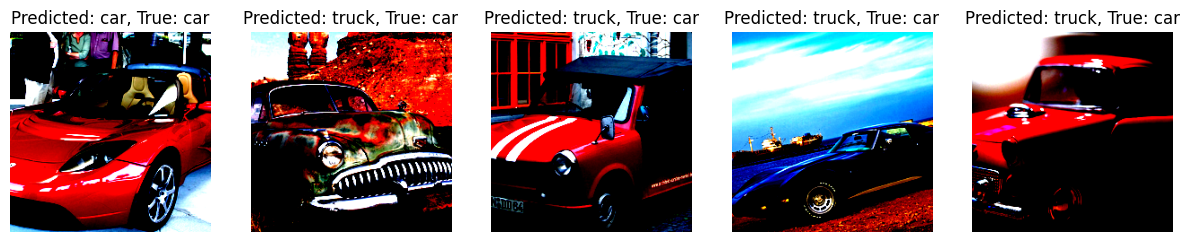

In [7]:
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

class_labels = ["car", "truck"]

# Visualize the predictions
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    img = images[i].cpu().numpy().transpose(1, 2, 0)
    axes[i].imshow(img)
    axes[i].set_title(f"Predicted: {class_labels[predicted[i].item()]}, True: {class_labels[labels[i].item()]}")
    axes[i].axis('off')
plt.show()
